### Model Training

#### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the processed data
df = pd.read_csv('../../data/processed/tft_match_data_with_features.csv')

In [3]:
unit_tier_columns = [col for col in df.columns if col.endswith('_tier')]
unit_rarity_columns = [col for col in df.columns if col.endswith('_rarity')]
trait_columns = [col for col in df.columns if col.endswith('_style')]

# Select features and target
X = df.drop(columns=['match_id', 'puuid', 'augments', 'activated_traits_list', 'units_on_board'] + unit_tier_columns + unit_rarity_columns + trait_columns)
y = df['placement']

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Make predictions
y_pred = model.predict(X_test)

In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        18
           2       0.80      0.92      0.86        13
           3       0.76      0.87      0.81        15
           4       0.91      0.48      0.62        21
           5       0.43      0.71      0.53        17
           6       0.87      0.68      0.76        19
           7       0.86      0.90      0.88        20
           8       0.91      1.00      0.95        10

    accuracy                           0.77       133
   macro avg       0.82      0.80      0.79       133
weighted avg       0.82      0.77      0.78       133



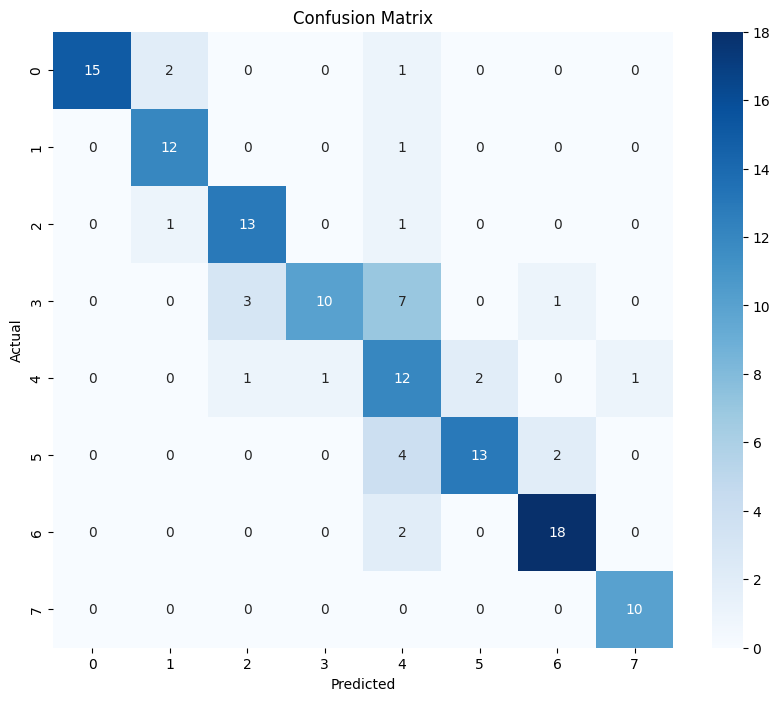

In [8]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

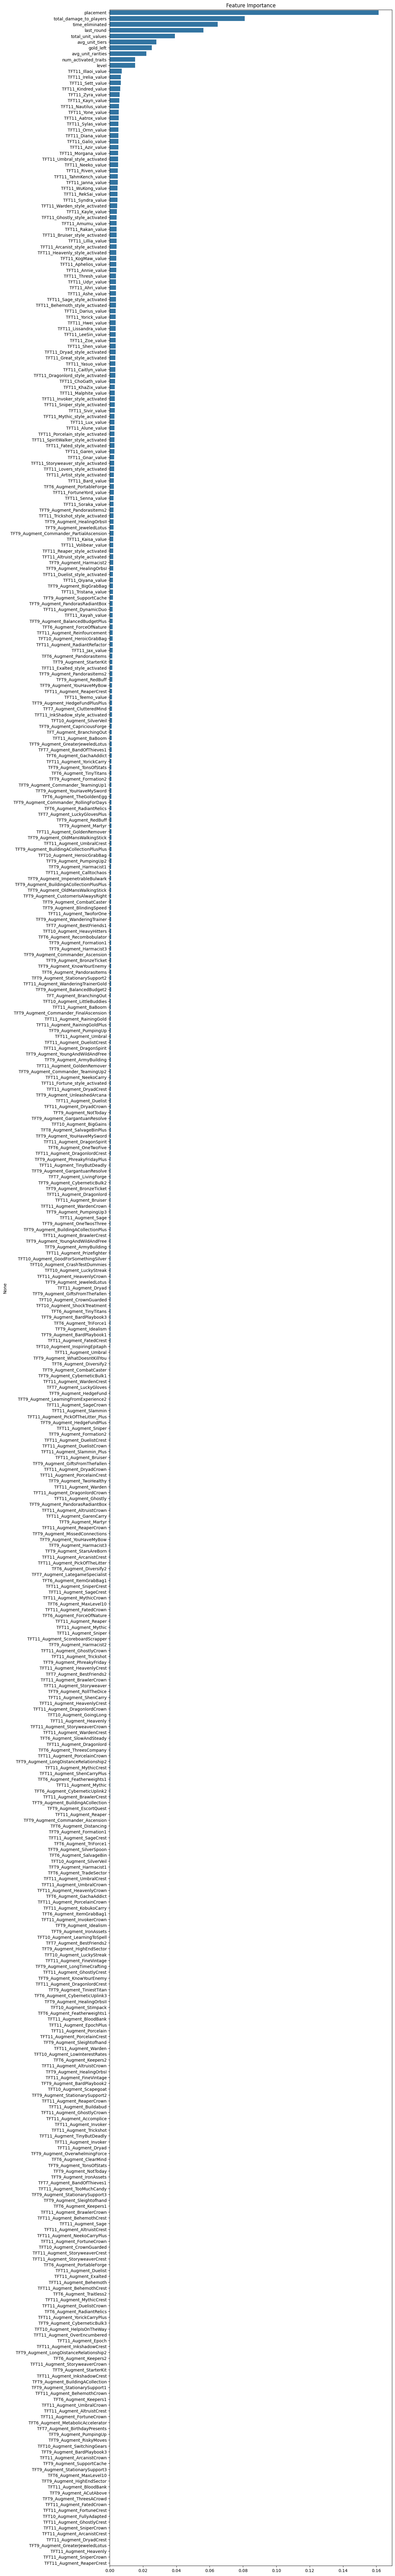

In [9]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, len(X.columns)/4))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance')
plt.show()

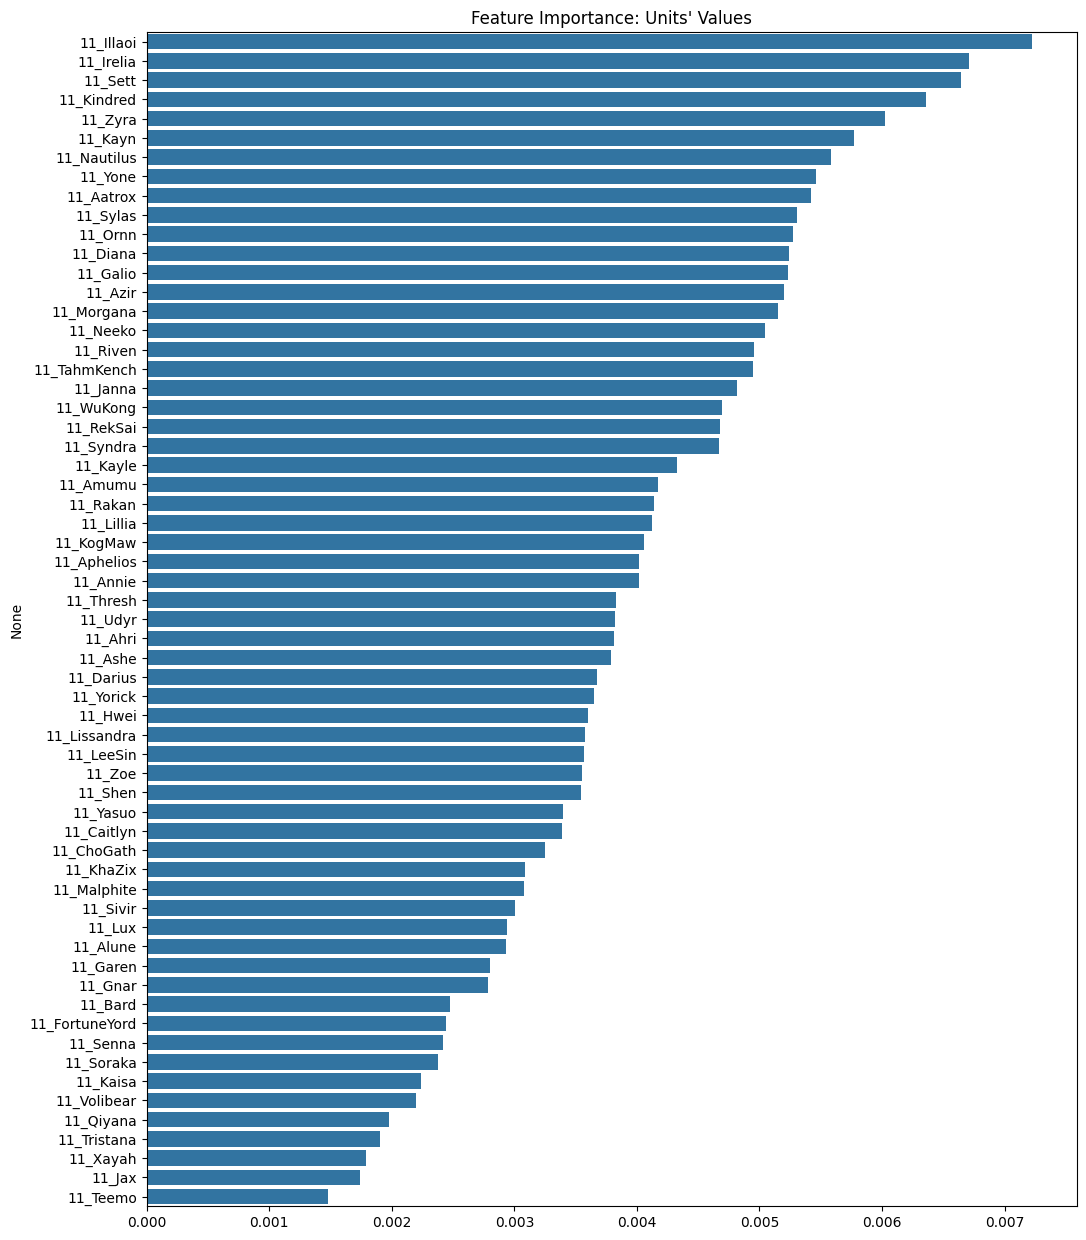

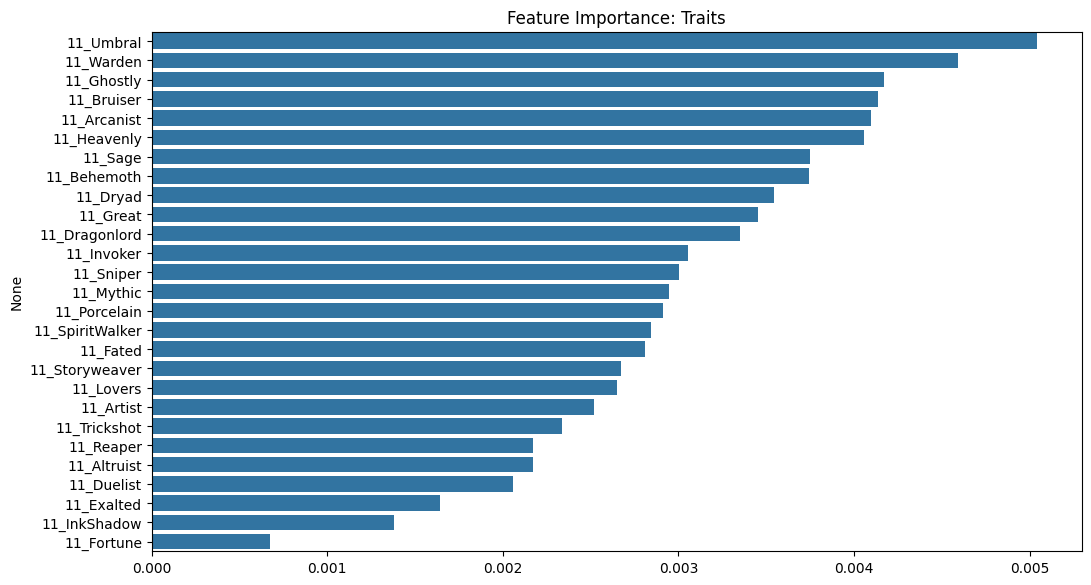

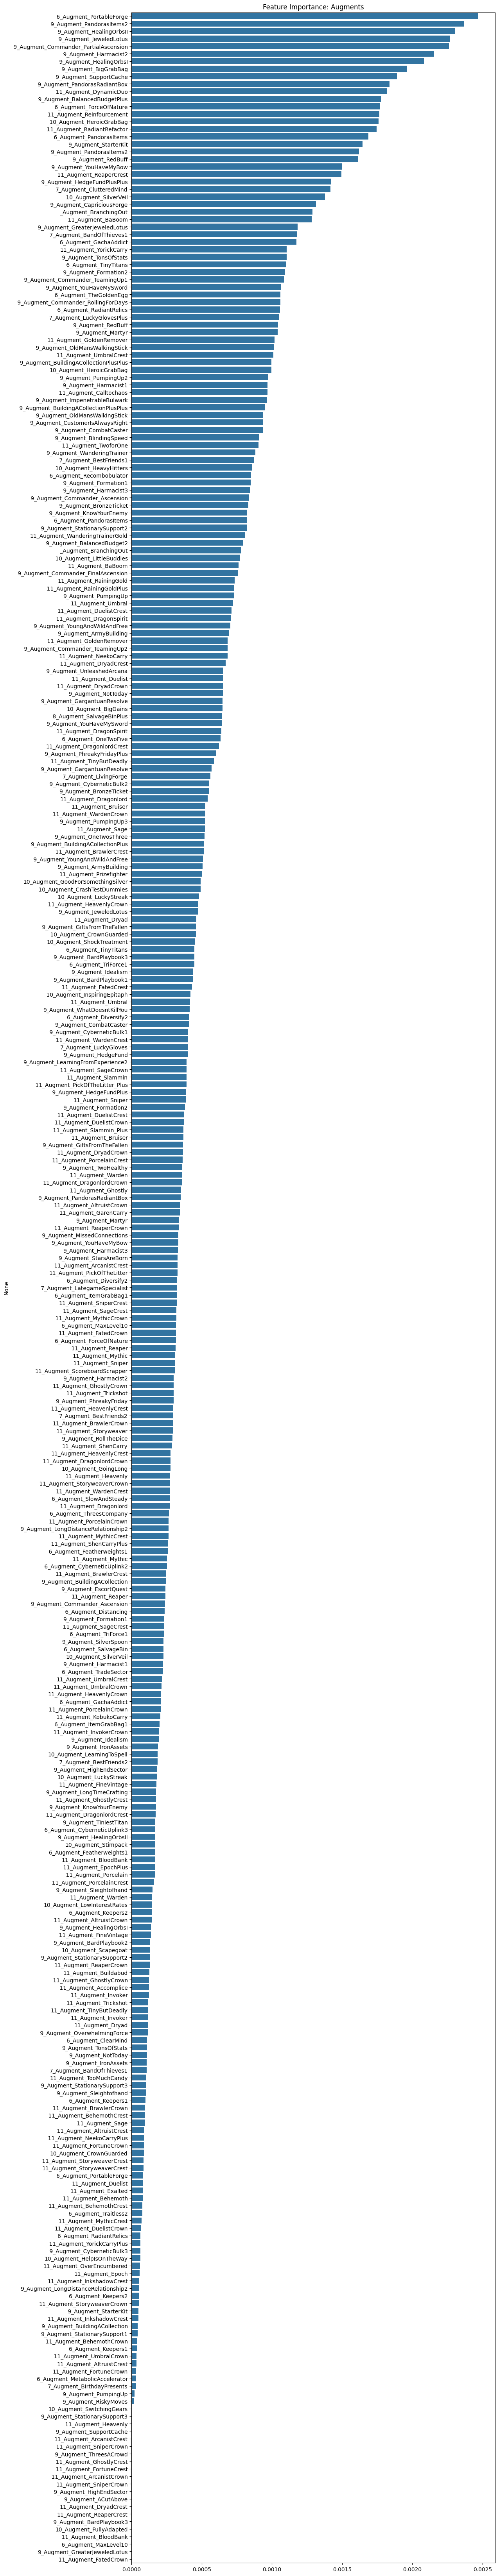

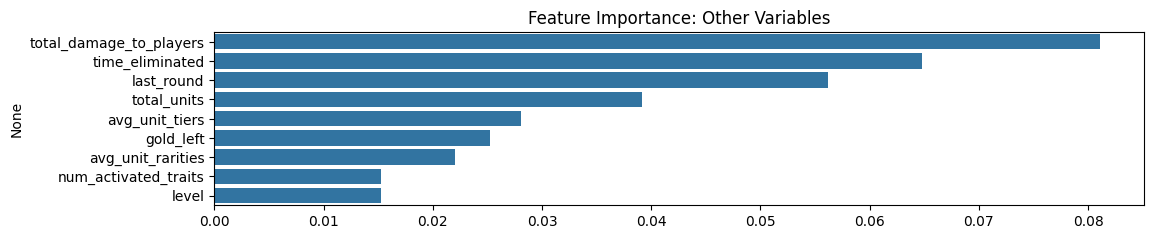

In [10]:
# Separate columns into different categories
value_columns = [col for col in X.columns if col.endswith('_value')]
activated_trait_columns = [col for col in X.columns if col.endswith('_style_activated')]
augment_columns = df.columns[df.columns.str.contains('Augment')].tolist()
other_columns = ['total_damage_to_players', 'last_round', 'time_eliminated', 'total_unit_values', 'avg_unit_tiers', 'avg_unit_rarities', 'gold_left', 'num_activated_traits', 'level']

# Function to plot feature importance
def plot_feature_importance(columns, title):
    feature_importance_subset = feature_importance[columns].sort_values(ascending=False)

    feature_importance_subset.index = [index.replace('_style_activated', '').replace('_value', '').replace('TFT', '') for index in feature_importance_subset.index] 

    plt.figure(figsize=(12, len(columns)/4))
    sns.barplot(x=feature_importance_subset.values, y=feature_importance_subset.index)
    plt.title(f'Feature Importance: {title}')
    plt.show()

# Plot feature importance for each category
plot_feature_importance(value_columns, 'Units\' Values')
plot_feature_importance(activated_trait_columns, 'Traits')
plot_feature_importance(augment_columns, 'Augments')
plot_feature_importance(other_columns, 'Other Variables')

#### Correlation Analysis

Top features negatively correlated with placement (contributing to better performance):
total_damage_to_players   -0.885942
last_round                -0.869430
time_eliminated           -0.841221
total_units               -0.616893
avg_unit_tiers            -0.452593
level                     -0.444776
num_activated_traits      -0.290994
avg_unit_rarities         -0.251827
11_Irelia                 -0.230799
11_WuKong                 -0.180868
Name: placement, dtype: float64

Top features positively correlated with placement (contributing to worse performance):
 9_Augment_NotToday           0.076405
 10_Augment_SilverVeil        0.077119
 11_Augment_BrawlerCrown      0.083960
11_Fortune                    0.087436
9_Augment_Formation1          0.087436
 11_Augment_FineVintage       0.093435
 7_Augment_BandOfThieves1     0.097141
11_Augment_DragonlordCrest    0.111135
gold_left                     0.224748
placement                     1.000000
Name: placement, dtype: float64


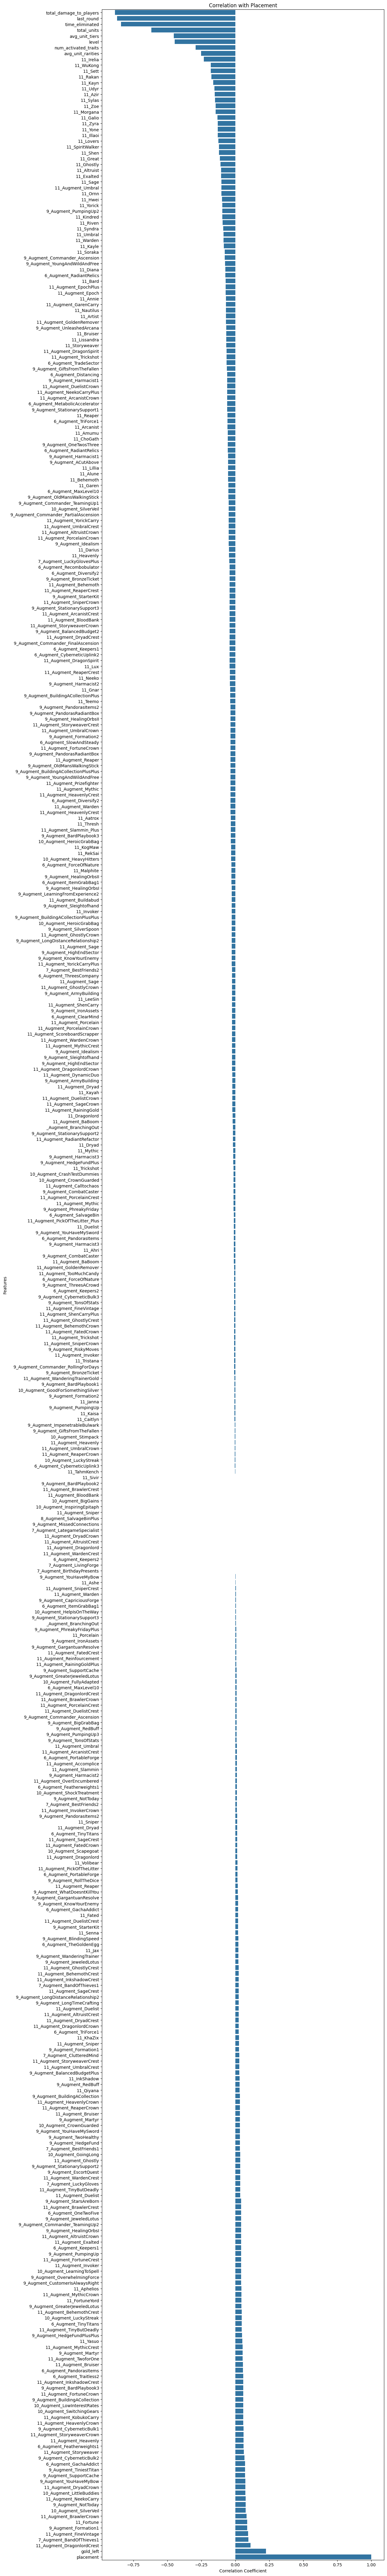

In [11]:
# Calculate correlations between features and placement
correlations = df.drop(columns=['match_id', 'puuid', 'augments', 'activated_traits_list', 'units_on_board'] + unit_tier_columns + unit_rarity_columns + trait_columns).corr()['placement'].sort_values()

correlations.index = [index.replace('_style_activated', '').replace('_value', '').replace('TFT', '') for index in correlations.index] 


# Display the top features negatively correlated with placement
print("Top features negatively correlated with placement (contributing to better performance):")
print(correlations.head(10))

# Display the top features positively correlated with placement
print("\nTop features positively correlated with placement (contributing to worse performance):")
print(correlations.tail(10))

# Plot the correlations
plt.figure(figsize=(12, len(correlations)/4))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Correlation with Placement')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [12]:
# Example function to make predictions given a board configuration
def predict_placement(model, board_config, feature_columns):
    # Create a DataFrame with a single row representing the board configuration
    input_df = pd.DataFrame([board_config])
    
    # Identify missing columns
    missing_cols = list(set(feature_columns) - set(input_df.columns))
    
    # Create a DataFrame with missing columns set to 0
    missing_df = pd.DataFrame(0, index=input_df.index, columns=missing_cols)
    
    # Concatenate the input DataFrame with the missing columns DataFrame
    input_df = pd.concat([input_df, missing_df], axis=1)
    
    # Ensure the columns match the training data
    input_df = input_df[feature_columns]
    
    # Make the prediction
    prediction = model.predict(input_df)
    return prediction[0]

# Example board configuration (update this with real values)
example_board = {
    'total_damage_to_players': 44,
    'time_eliminated': 1743.713134765625,
    'gold_left': 1,
    'last_round': 28,
    'level': 8,
    'num_activated_traits': 3,
    'total_unit_values': 1000,
    'avg_unit_tiers': 2.5,
    'avg_unit_rarities': 3.5,
    'TFT9_Augment_WhatDoesntKillYou': 1,
    'TFT9_Augment_BigGrabBag': 1,
    'TFT9_Augment_JeweledLotus': 1,

    # ... add more features based on your model
}

feature_columns = X.columns.tolist()

# Predict the placement
predicted_placement = predict_placement(model, example_board, feature_columns)
print(f"Predicted Placement: {predicted_placement}")

Predicted Placement: 7


### Reinforcement Learning Using Deep Learning

In [21]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers
from numba import cuda

class TFTEnvironment:
    def __init__(self):
        self.state_size = 50  # Example state size
        self.action_size = 10  # Example action size
        self.state = np.zeros(self.state_size)
        self.episode_length = 200  # Longer episodes
        self.current_step = 0

    def reset(self):
        self.state = np.zeros(self.state_size)
        self.current_step = 0
        return self.state

    def step(self, action):
        reward = self.calculate_reward(action)
        self.state[action] += 1
        self.current_step += 1
        done = self.current_step >= self.episode_length
        return self.state, reward, done

    def calculate_reward(self, action):
        # Complex reward logic
        base_reward = random.random() * (action + 1)
        
        # Example additional factors
        synergy_bonus = self.get_synergy_bonus(action)
        placement_penalty = self.get_placement_penalty()
        damage_dealt_bonus = self.get_damage_dealt_bonus(action)
        survival_time_bonus = self.get_survival_time_bonus()
        
        reward = base_reward + synergy_bonus + damage_dealt_bonus + survival_time_bonus - placement_penalty
        return reward

    def get_synergy_bonus(self, action):
        # Placeholder logic for synergy bonus
        return random.random() * 2 if self.state[action] >= 2 else 0

    def get_placement_penalty(self):
        # Placeholder logic for placement penalty
        return random.random() * 1.5 if self.current_step < self.episode_length / 2 else 0

    def get_damage_dealt_bonus(self, action):
        # Placeholder logic for damage dealt bonus
        return random.random() * action

    def get_survival_time_bonus(self):
        # Placeholder logic for survival time bonus
        return random.random() * (self.episode_length - self.current_step) / self.episode_length

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            layers.Input(shape=(self.state_size,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Create an environment instance
env = TFTEnvironment()

# Create an agent instance
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

# Training the DQN agent
episodes = 1000
batch_size = 32

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    for time in range(env.episode_length):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, env.state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{episodes}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

# Save the trained model
agent.model.save('../models/saved_models/complex_dqn_model.keras')

# Convert to ONNX
import tf2onnx

# Load the saved model
model = tf.keras.models.load_model('../models/saved_models/complex_dqn_model.keras')

# Convert the model to ONNX format
spec = (tf.TensorSpec((None, env.state_size), tf.float32, name="input"),)
output_path = "complex_dqn_model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path)

print(f"ONNX model saved to {output_path}")

# Optimize with TensorRT Model Optimizer
import subprocess

# Path to the ONNX model
onnx_model_path = "complex_dqn_model.onnx"

# Path to save the optimized model
optimized_model_path = "complex_dqn_model_optimized.onnx"

# Run the model optimizer
subprocess.run([
    "nvidia-modelopt",
    "--input_model", onnx_model_path,
    "--output_model", optimized_model_path,
    "--enable_quantization",
    "--enable_sparsity"
])

print(f"Optimized model saved to {optimized_model_path}")

# Compare performance
import onnxruntime as ort

# Load the optimized model
optimized_model = ort.InferenceSession(optimized_model_path)

# Function to make predictions
def predict_onnx(model, input_data):
    input_name = model.get_inputs()[0].name
    return model.run(None, {input_name: input_data})[0]

# Generate a sample input
input_data = np.random.rand(1, env.state_size).astype(np.float32)

# Predict with the optimized model
output_optimized = predict_onnx(optimized_model, input_data)

print(f"Optimized Model Output: {output_optimized}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import random

#### Creating a Custom Environment

In [14]:
class TFTEnvironment:
    def __init__(self):
        self.state_size = 50  # Example state size
        self.action_size = 10  # Example action size
        self.state = np.zeros(self.state_size)
        self.episode_length = 200  # Longer episodes
        self.current_step = 0

    def reset(self):
        self.state = np.zeros(self.state_size)
        self.current_step = 0
        return self.state

    def step(self, action):
        reward = self.calculate_reward(action)
        self.state[action] += 1
        self.current_step += 1
        done = self.current_step >= self.episode_length
        return self.state, reward, done

    def calculate_reward(self, action):
        # Complex reward logic
        base_reward = random.random() * (action + 1)
        
        # Example additional factors
        synergy_bonus = self.get_synergy_bonus(action)
        placement_penalty = self.get_placement_penalty()
        damage_dealt_bonus = self.get_damage_dealt_bonus(action)
        survival_time_bonus = self.get_survival_time_bonus()
        
        reward = base_reward + synergy_bonus + damage_dealt_bonus + survival_time_bonus - placement_penalty
        return reward

    def get_synergy_bonus(self, action):
        # Placeholder logic for synergy bonus
        return random.random() * 2 if self.state[action] >= 2 else 0

    def get_placement_penalty(self):
        # Placeholder logic for placement penalty
        return random.random() * 1.5 if self.current_step < self.episode_length / 2 else 0

    def get_damage_dealt_bonus(self, action):
        # Placeholder logic for damage dealt bonus
        return random.random() * action

    def get_survival_time_bonus(self):
        # Placeholder logic for survival time bonus
        return random.random() * (self.episode_length - self.current_step) / self.episode_length

env = TFTEnvironment()

In [15]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


#### DQN(Deep Q-Network) Agent

In [17]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            layers.Input(shape=(self.state_size,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Create an agent instance
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

#### Training the Agent

In [19]:
# Training the DQN agent
episodes = 100
batch_size = 32

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    for time in range(env.episode_length):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, env.state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{episodes}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
agent.model.save('../model/saved_models/dqn_model.keras')